# Оценка линейного искажающего оператора в задаче восстановления изображений
Время работы: 8:40с

In [1]:
import numpy as np
from skimage import color, data, img_as_float, io
from scipy.signal import convolve2d

from functools import partial
from scipy.optimize import minimize

from util import *
from richardson_lucy import *

In [26]:
import skimage

In [27]:
skimage.measure.compare_psnr?

In [2]:
prefix = "linear"

In [3]:
iterations = 30
astro = color.rgb2gray(data.astronaut())
liftingbody = img_as_float(io.imread('liftingbody.png'))
#liftingbody = edgetaper(liftingbody, gkern2(41,6))

## Линейный оператор смаза

In [4]:
np.round(motion_blur_psf_my(x=3,y=-4.5),3)

0 4.5 3 0


array([[0.   , 0.   , 0.   , 0.249, 0.   ],
       [0.   , 0.   , 0.145, 0.042, 0.   ],
       [0.   , 0.042, 0.146, 0.   , 0.   ],
       [0.   , 0.249, 0.   , 0.   , 0.   ],
       [0.083, 0.042, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ]])

0 0 15.000000000000004 25.980762113533157


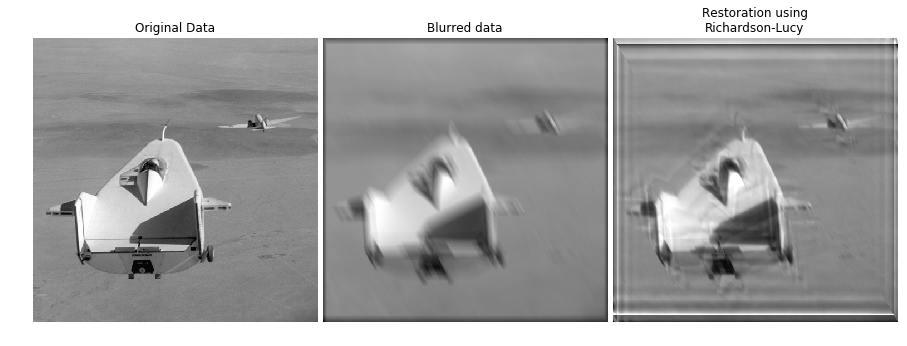

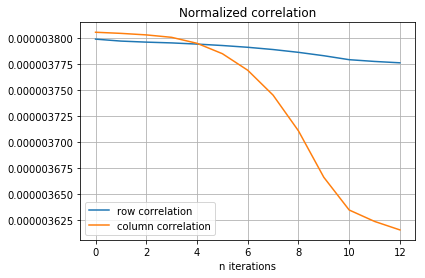

(0.976274976662166, 0.0) (0.9742919392422129, 0.0)


In [5]:
shift = 30
psf = motion_blur_psf_my(shift, pi/3)
lifting_blurred = convolve2d(liftingbody, psf, 'same')
iterations = 12
deconv = richardson_lucy_matlab(lifting_blurred, psf, iterations=iterations, eps=1e-5, clip=True, dampar=0.004)
show_results(liftingbody, lifting_blurred, deconv['image'])
plot_corr(iterations+1, [deconv['correlationX'], 
                         deconv['correlationY']])
correlation_X = pearsonr(liftingbody.ravel('C')[:-1], liftingbody.ravel('C')[1:])
correlation_Y = pearsonr(liftingbody.ravel('F')[:-1], liftingbody.ravel('F')[1:])
print(correlation_X, correlation_Y)

In [6]:
psf.shape

(27, 17)

In [7]:
a = np.zeros((100, 100))

In [8]:
a[50-13:50+14, 50-8:50+9] = psf[:,:]

In [9]:
npArrayToPng(a, "pic/{0}-psf-arr.png".format(prefix))

In [10]:
npArrayToPng(np.abs(fftn(a)), "pic/{0}-psf-fourier.png".format(prefix))

## Неверная psf

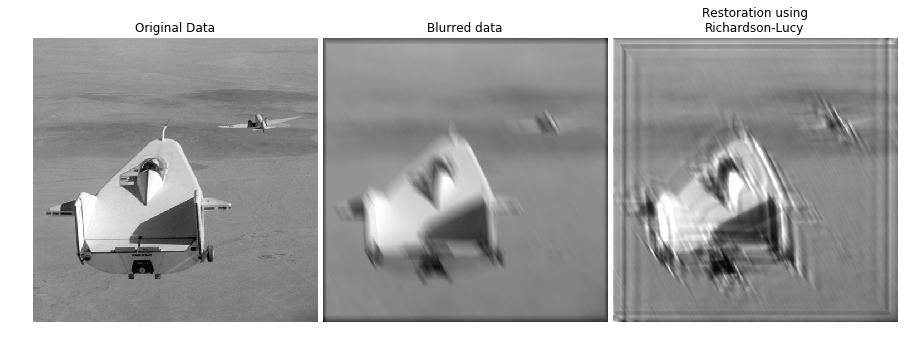

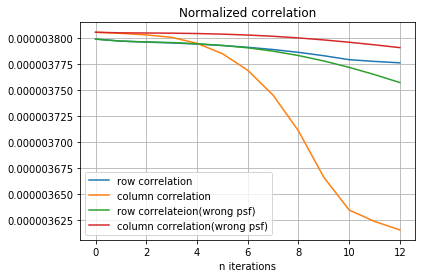

In [11]:
psf_wrong = motion_blur_psf(shift, pi/4)
deconv_wrong = richardson_lucy_matlab(lifting_blurred, psf_wrong, iterations=iterations, eps=1e-5)
show_results(liftingbody, lifting_blurred, deconv_wrong['image'])
plot_corr(iterations+1, [deconv['correlationX'], 
                         deconv['correlationY'],
                         deconv_wrong['correlationX'],
                         deconv_wrong['correlationY']], 
          legend=['row correlation', 'column correlation', 'row correlateion(wrong psf)', 'column correlation(wrong psf)'])

## Использование параметра dampar

In [12]:
s_n, S_find = find_noise(liftingbody)
print(s_n)

0.004225632509230561


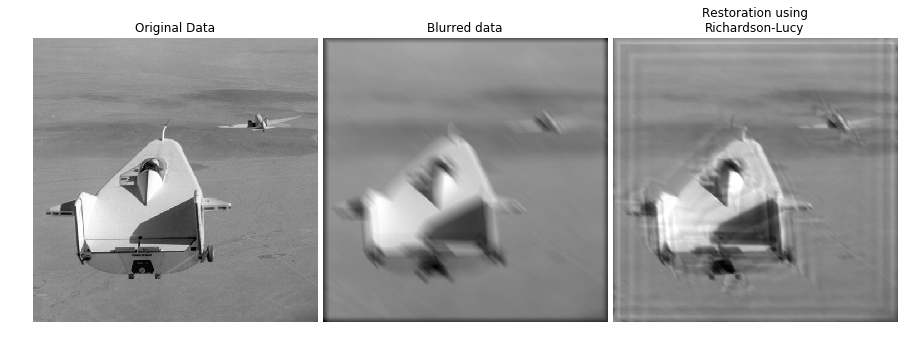

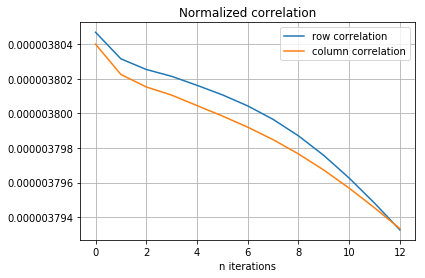

In [13]:
psf = motion_blur_psf(shift, pi/4)
x0_ref = [shift * np.cos(pi/4), shift * np.sin(pi/4)]
lifting_blurred = convolve2d(liftingbody, psf, 'same')
deconv = richardson_lucy_matlab(lifting_blurred, psf, iterations=iterations, eps=1e-5, clip=True, dampar=s_n, useFFT=True)
show_results(liftingbody, lifting_blurred, deconv['image'])
plot_corr(iterations+1, [deconv['correlationX'], 
                         deconv['correlationY']])

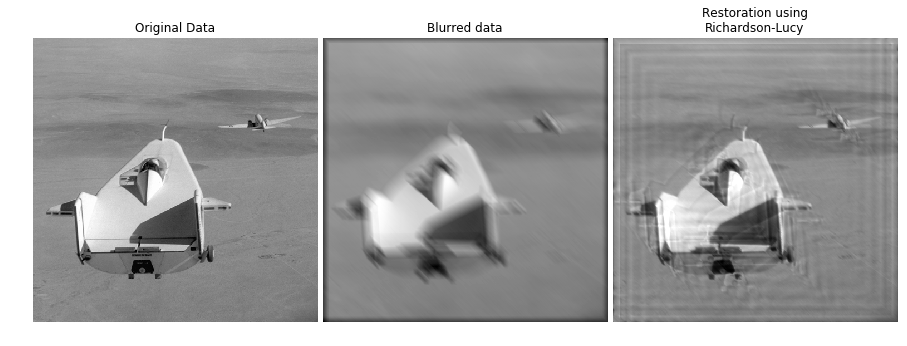

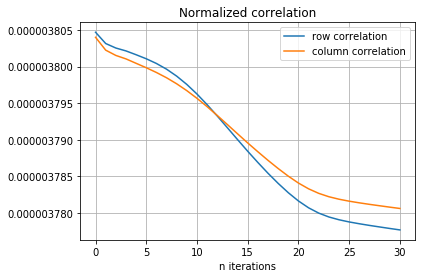

In [14]:
angle = pi/4 #5*pi/16
psf = motion_blur_psf(shift, angle)
x0_ref = [shift * np.cos(angle), shift * np.sin(angle)]
lifting_blurred = convolve2d(liftingbody, psf, 'same')
iterations = 30
deconv = richardson_lucy_matlab(lifting_blurred, psf, iterations=iterations, eps=1e-5, clip=True, dampar=s_n, useFFT=True)
show_results(liftingbody, lifting_blurred, deconv['image'])
plot_corr(iterations+1, [deconv['correlationX'], 
                         deconv['correlationY']])

### dampar и неверная psf

0 0 15.000000000000004 25.980762113533157


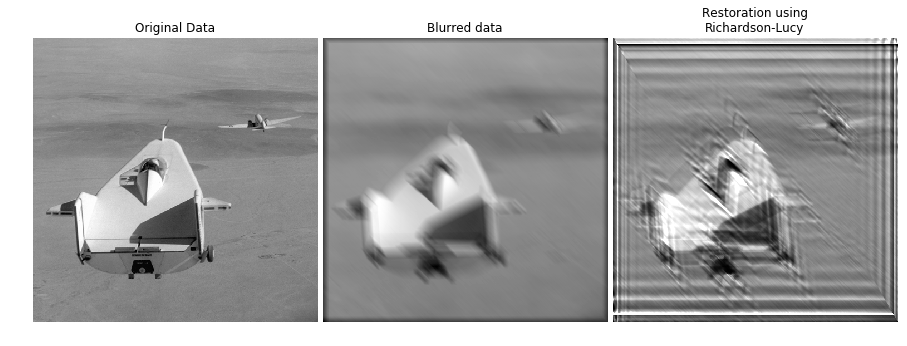

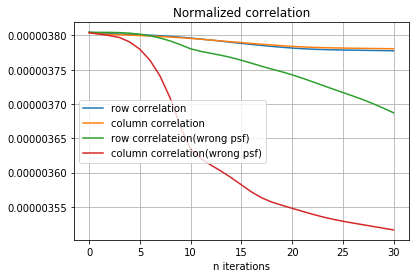

In [15]:
psf_wrong = motion_blur_psf_my(shift, pi/3)
deconv_wrong = richardson_lucy_matlab(lifting_blurred, psf_wrong, iterations=iterations, eps=1e-5, dampar=s_n)
show_results(liftingbody, lifting_blurred, deconv_wrong['image'])
plot_corr(iterations+1, [deconv['correlationX'], 
                         deconv['correlationY'],
                         deconv_wrong['correlationX'],
                         deconv_wrong['correlationY']], 
          legend=['row correlation', 'column correlation', 'row correlateion(wrong psf)', 'column correlation(wrong psf)'])

## Кепстр
$$K = F^{-1}\{log(1+\left|F\{I\}\right|)\}$$

In [16]:
N,M = lifting_blurred.shape
# ( ifft2 (100* log (1+ abs ( fft2 ( I ) ) ) ) ) ;
K = np.fft.ifftn(100*np.log(1+np.abs(np.fft.fftn(lifting_blurred))))
K_shift = np.fft.fftshift(K)

In [17]:
nn = np.argmin(np.real(K_shift))
n, m, = K_shift.shape
c,r = np.unravel_index(np.argmin(K_shift, axis=None), K_shift.shape)
x0 = [r - n//2, c - m//2]
print(x0)

[22, 22]


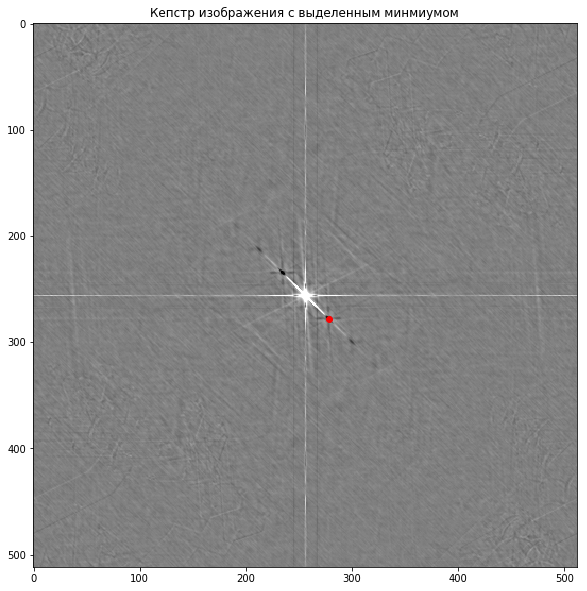

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(np.real(K_shift),-1,1))#, vmin=noisy.min(), vmax=noisy.max())
plt.plot(n//2 + x0[1], m//2 + x0[0], 'ro')
plt.title('Кепстр изображения с выделенным минмиумом')
plt.savefig('pic/{0}-kepstr.png'.format(prefix))
plt.show()

## Уточнение искажающего оператора
$$\varepsilon = ||\tilde{I}\oplus\tilde{h}-I_0|| \to \min_{(x,y)}$$
Пусть $$\tilde{I}\oplus(\tilde{h}+\tilde{dh})=I_0$$
Тогда $$\tilde{I}\oplus\tilde{dh}=I_0-\tilde{I}\oplus\tilde{h}$$
Получим задачу аналогичную исходной($\tilde{I}\oplus h +\eta = I_0$)

```python
img_diff = liftingbody - convolve2d(deconv['image'], psf, mode='same') # Утечка
deconv_psf = richardson_lucy_matlab(img_diff, deconv['image'], iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True)
psf_new = deconv_psf['image']
deconv_upd = richardson_lucy_matlab(lifting_blurred, psf_new, iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True)
show_results(lifting_blurred, deconv['image'], deconv_upd['image'],
             titles=['blurred', 'restored', 'restored with\nnew psf'])
plot_corr(iterations+1, [deconv['correlationX'], 
                         deconv['correlationY'],
                         deconv_upd['correlationX'],
                         deconv_upd['correlationY']], 
          legend=['row correlation', 'column correlation', 'row correlateion(new psf)', 'column correlation(new psf)'])
```

Такой подход не сработал :( Будем использовать метод Ньютона
## Уточнение искажающего оператора

$$(x,y)^T_{n+1} = (x, y)^T_{n} - H^{-1}(f(x,y))\nabla f(x,y)$$
$$H(f) =$$

In [19]:
def funcToMinimize(xy, I_blurred, crop=100, *args, **kwargs):
    psf = motion_blur_psf_my(x=xy[0], y=xy[1])
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [20]:
partial(funcToMinimize, I_blurred=lifting_blurred, iterations=iterations, eps=1e-5, dampar=s_n, clip=True, useFFT=True)([10,10])

0 0 10 10


8.197827996102787e-06

In [21]:
cos(angle)*shift

21.213203435596427

### Минимизация методом Нелдера-Мида (симплекс-метод)
Method Nelder-Mead uses the Simplex algorithm [1], [2]. This algorithm is robust in many applications. However, if numerical computation of derivative can be trusted, other algorithms using the first and/or second derivatives information might be preferred for their better performance in general.

Method Powell is a modification of Powell’s method [3], [4] which is a conjugate direction method. It performs sequential one-dimensional minimizations along each vector of the directions set (direc field in options and info), which is updated at each iteration of the main minimization loop. The function need not be differentiable, and no derivatives are taken.

Method CG uses a nonlinear conjugate gradient algorithm by Polak and Ribiere, a variant of the Fletcher-Reeves method described in [5] pp. 120-122. Only the first derivatives are used.

Method BFGS uses the quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno (BFGS) [5] pp. 136. It uses the first derivatives only. BFGS has proven good performance even for non-smooth optimizations. This method also returns an approximation of the Hessian inverse, stored as hess_inv in the OptimizeResult object.

Method Newton-CG uses a Newton-CG algorithm [5] pp. 168 (also known as the truncated Newton method). It uses a CG method to the compute the search direction. See also TNC method for a box-constrained minimization with a similar algorithm. Suitable for large-scale problems.

Method dogleg uses the dog-leg trust-region algorithm [5] for unconstrained minimization. This algorithm requires the gradient and Hessian; furthermore the Hessian is required to be positive definite.

Method trust-ncg uses the Newton conjugate gradient trust-region algorithm [5] for unconstrained minimization. This algorithm requires the gradient and either the Hessian or a function that computes the product of the Hessian with a given vector. Suitable for large-scale problems.

Method trust-krylov uses the Newton GLTR trust-region algorithm [14], [15] for unconstrained minimization. This algorithm requires the gradient and either the Hessian or a function that computes the product of the Hessian with a given vector. Suitable for large-scale problems. On indefinite problems it requires usually less iterations than the trust-ncg method and is recommended for medium and large-scale problems.

Method trust-exact is a trust-region method for unconstrained minimization in which quadratic subproblems are solved almost exactly [13]. This algorithm requires the gradient and the Hessian (which is not required to be positive definite). It is, in many situations, the Newton method to converge in fewer iteraction and the most recommended for small and medium-size problems.

```
from scipy.optimize import minimize

res = minimize(partial(funcToMinimize, I_blurred=lifting_blurred, iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True),
               x0=x0, method='nelder-mead',
               options={'xtol': 1e-3, 'disp': True})
```

```
from scipy.optimize import minimize

res = minimize(partial(funcToMinimize, I_blurred=lifting_blurred, iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True),
               x0=x0, method='powell',
               options={'xtol': 1e-3, 'disp': True})
```

## Метод Ньютона

In [22]:
res_tnc = minimize(partial(funcToMinimize, I_blurred=lifting_blurred, iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True),
               x0=x0, method='TNC', options={'xtol':1e-3})
print(res_tnc)

0 0 22.0 22.0
0 0 22.0 22.0
0 0 22.00000001 22.0
0 0 22.0 22.00000001
0 0 21.999999795106486 21.99999972526332
0 0 21.999999795106486 21.99999972526332
0 0 21.999999805106487 21.99999972526332
0 0 21.999999795106486 21.99999973526332
0 0 21.999999453110657 21.99999926668951
0 0 21.999999453110657 21.99999926668951
0 0 21.999999463110658 21.99999926668951
0 0 21.999999453110657 21.99999927668951
0 0 21.999996718663937 21.999995600137055
0 0 21.999996718663937 21.999995600137055
0 0 21.999996728663938 21.999995600137055
0 0 21.999996718663937 21.999995610137056
0 0 21.999928357495925 21.99990393632569
0 0 21.999928357495925 21.99990393632569
0 0 21.999928367495926 21.99990393632569
0 0 21.999928357495925 21.99990394632569
0 0 21.99138321149476 21.98844595990506
0 0 21.99138321149476 21.98844595990506
0 0 21.99138322149476 21.98844595990506
0 0 21.99138321149476 21.98844596990506
0 0 16.65066696076651 14.827210697011385
0 0 16.65066696076651 14.827210697011385
0 0 16.650666970766512 14.82

In [23]:
res_tnc['x']

array([21.32691266, 21.09747387])

0 0 22 22
0 0 21.32691266384187 21.097473866527665


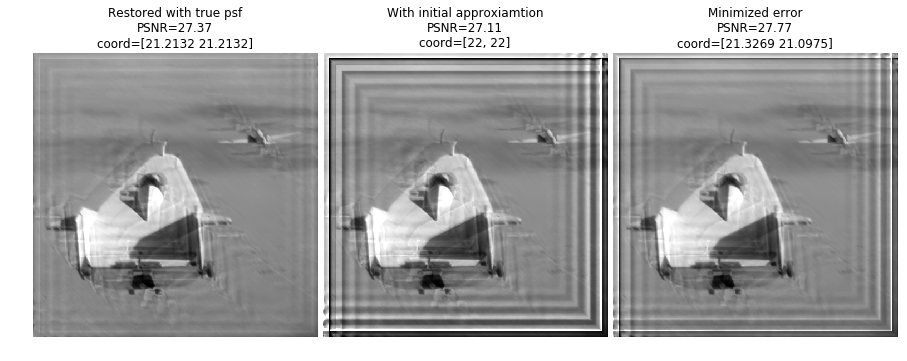

In [24]:
deconv_orig = richardson_lucy_matlab(lifting_blurred, psf, iterations=iterations, dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = motion_blur_psf_my(x=x0[0], y=x0[1])
deconv_init = richardson_lucy_matlab(lifting_blurred, psf_init, iterations=iterations, dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

x_found, y_found = res_tnc['x']
psf_found = motion_blur_psf_my(x=x_found, y=y_found)
deconv_found = richardson_lucy_matlab(lifting_blurred, psf_found, iterations=iterations, dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(2), np.round(x0_ref,4)), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), x0),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), res_tnc['x'].round(4))],
            savefig="pic/{0}-psf-estimation.png".format(prefix))

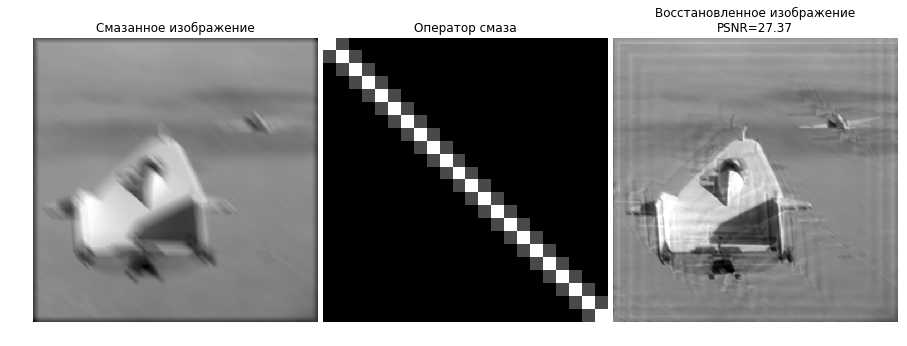

In [25]:
show_results(lifting_blurred, psf, deconv_orig['image'],
            titles=['Смазанное изображение', 'Оператор смаза', 'Восстановленное изображение\nPSNR={0}'.format(psnr_orig.round(2))],
            savefig='pic/{0}-with-psf.png'.format(prefix))